In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu
import funs as fu
import geopandas

import matplotlib.gridspec as gridspec

from sklearn.linear_model import ElasticNetCV

import cartopy.crs as ccrs


## constants and functions

In [2]:

# PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

# PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

# PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

# PATH_TO_BC = '../data_in/black_carbon_channel6_masked_5min.csv'
# PATH_TO_BC = '../data_in/black_carbon_channel6_raw_5min.csv'


PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

PATH_200_CLUS = '../data_out/cluster1000.nc'

OUT_FILE = '../data_out2/20_clus_SA_sources_inverse.csv'
OUT_DS_FILE = '../data_out2/DS_20__SA_sources_inverse.nc'
OUT_CONTRS_FILE = '../data_out2/CONTRS_20__SA_sources_inverse.csv'

OUT_MEAS_FILE = '../data_out2/MEAS_20__SA_sources_inverse.csv'


LA = 'lat'
LO = 'lon'
AT = 'AIRTRACER'
L = 'lab'

SA = 'sa'
MSA = 'msa'
IA = 'ia'

BC = 'bc_masked_ngm3'
# BC = 'bc_raw_ngm3'

LBC = 'log(bc)'

LSA = 'log10(sa)'
LMSA = 'log10(msa)'
LIA = 'log10(ia)'

DATA_OUT = '../data_out'

In [3]:
PAR = SA
#

# open and plot PAR timeseries

In [4]:
def _get_df():
    df = pd.read_csv(PATH_TO_ST, index_col=0, parse_dates=True)
    zeros = df[MSA] > 0
    print('zeros vs non zeros')
    print(zeros.value_counts())
    df = df[zeros]
    return df

df = _get_df()

zeros vs non zeros
True     27170
False      231
Name: msa, dtype: int64


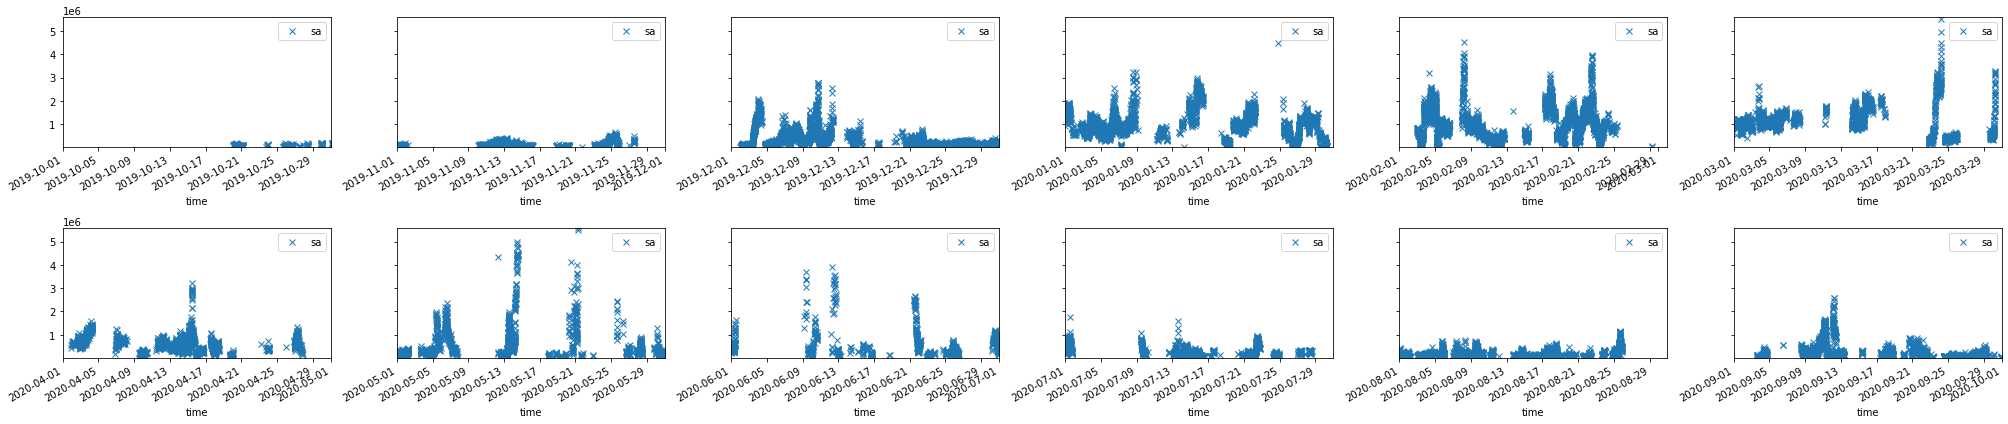

In [5]:
def plt_1(df,ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 5))
    df[[PAR]].plot(ax=ax, marker='x', lw=0)
    
def mplt(df):
    qm,qM = df[PAR].quantile([0,.999])
    f,axs = plt.subplots(2,6,sharey=True,figsize=(28,6))
    axf =axs.flatten()
    mm = df.index.min()
    mM = df.index.max()

    ms = [m.strftime('%Y-%m') for m in pd.date_range(mm, mM, freq='M')]
    for i,m in enumerate(ms):
        plt_1(df.loc[m],ax=axf[i])
        ax = axf[i]
        m_ = pd.to_datetime(m)+pd.Timedelta(30,'D')
#         print(m_)
        ax.set_xlim(pd.to_datetime(m), m_)
        ax.set_ylim(qm,qM)
#         ax.set_yscale('symlog',linthresh=1e5,linscale=.1)
#         ax.set_yticks([0,*[a*10**5 for a in range(1,10)],1e5,1e6,1e7])
    f.tight_layout()
    
mplt(df)

(0.0, 10340338.514111329)

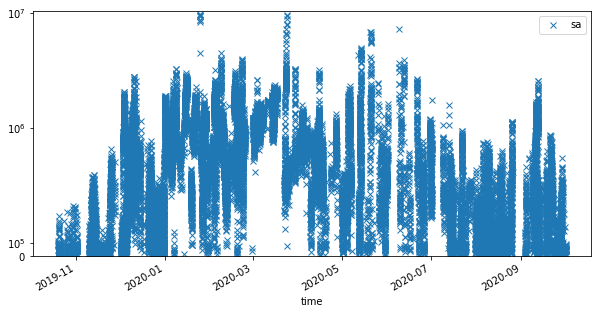

In [6]:
plt_1(df)
plt.gca().set_yscale('symlog',linthresh=1e5,linscale=.1)
plt.gca().set_ylim(0,None)

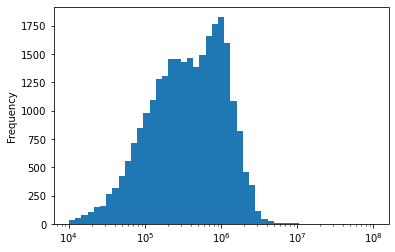

In [7]:
def _plt_dist(df):
    df[PAR].plot.hist(bins=np.geomspace(1e4, 1e8))
    plt.gca().set_xscale('log')
_plt_dist(df)

# open and merge flex 200 ro 1000 clusters

In [8]:
ds = xr.open_dataset(PATH_200_CLUS)

In [9]:
def _merge_ds_and_df(ds,df):
    dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

    df1 = df

    df2 = df1.resample('3H').median()

    dm = pd.merge(df2, dsf, left_index=True, right_index=True, how='inner', validate="1:1")
    return dm,dsf 
dm,dsf = _merge_ds_and_df(ds,df)

# 1st CV Inverse modeling elastic NET

23.222410239076627 0.9999


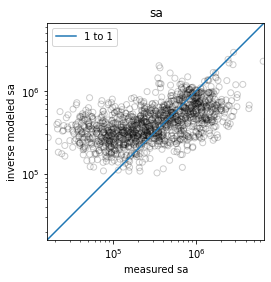

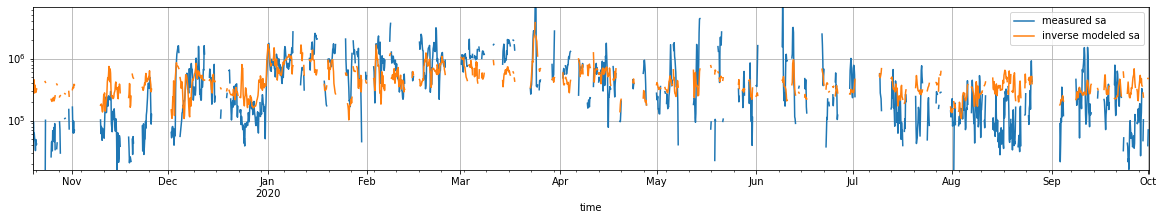

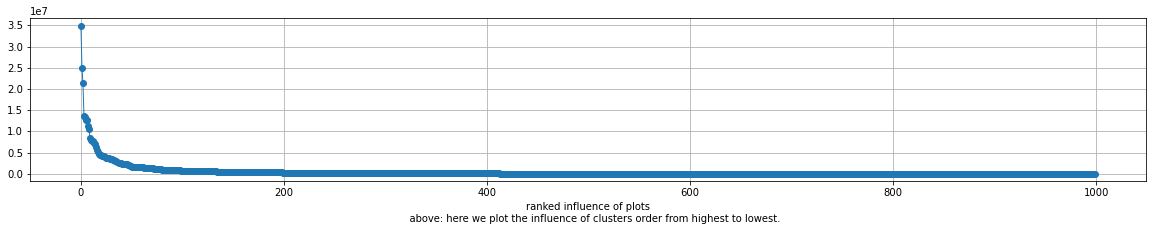

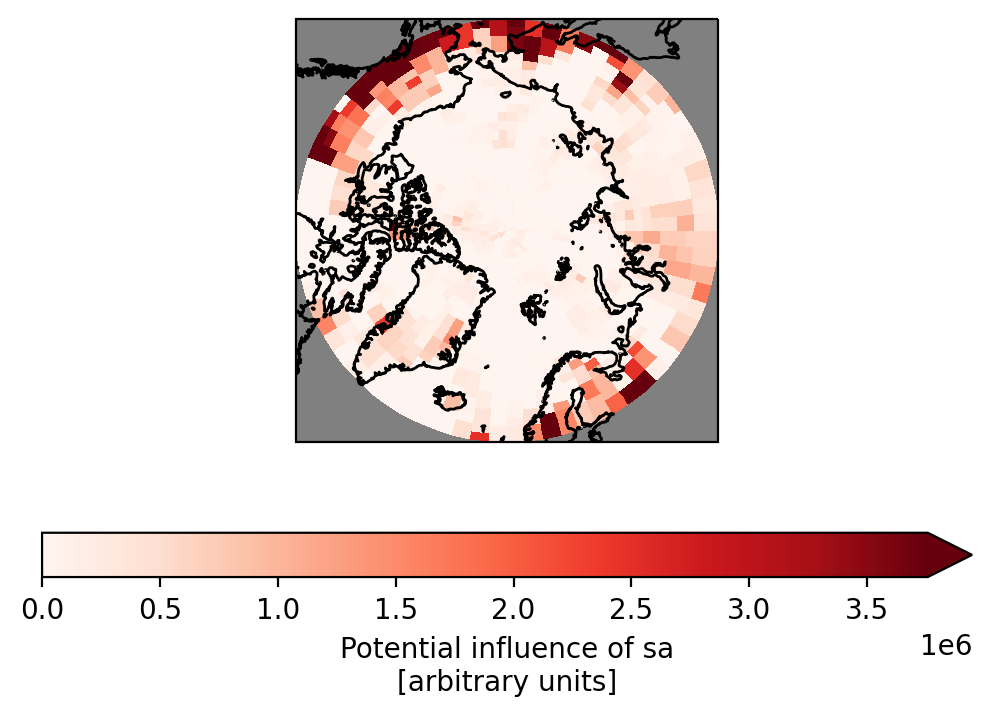

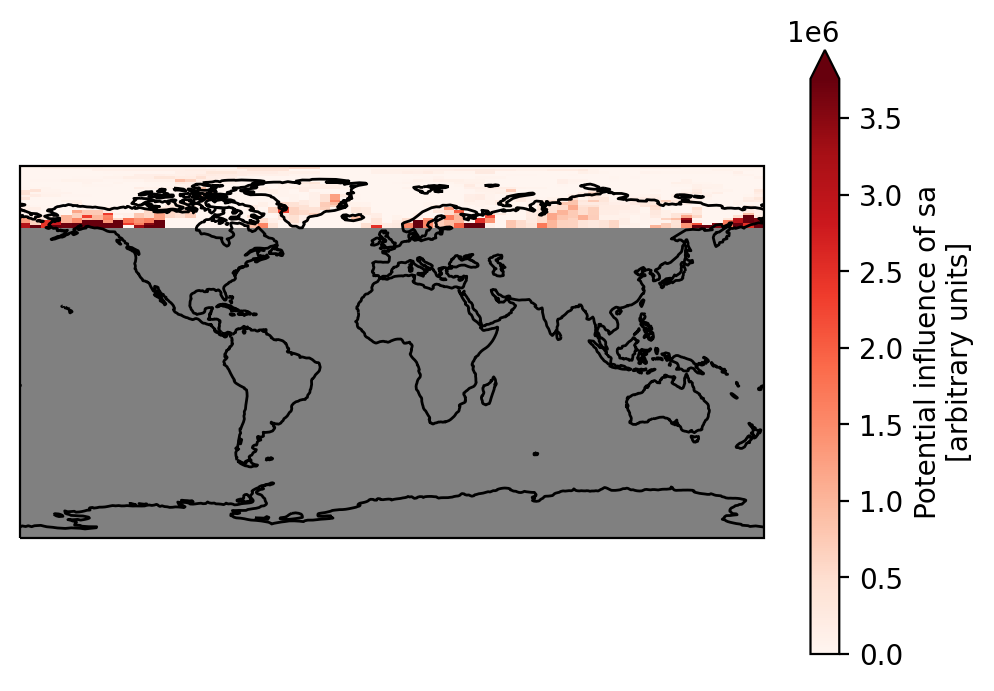

In [10]:
# for PAR in [SA,MSA,IA]:
def plt_el_net(dsf,dm):
    pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp, pred, MEA, MOD)
    rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr

    
regr = plt_el_net(dsf,dm)

In [11]:
pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

23.222410239076627 0.9999


In [12]:
def get_rat(dp,y,yn):
    from sklearn.linear_model import LinearRegression

    lr = LinearRegression(fit_intercept=True).fit(dp[yn].to_frame(),y[yn])
    
    r2 = lr.score(dp[yn].to_frame(),y[yn])
    coef = lr.coef_.item()
    inte = lr.intercept_

    return r2,coef, inte
r2, rat,inte = get_rat(dp,y,yn)
rat, r2,inte

(1.24744713306427, 0.2741335732559712, -37853.188)

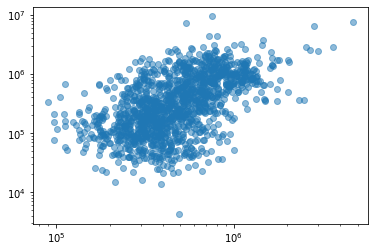

In [13]:
plt.scatter(dp[yn]*rat+inte,y[yn],alpha=.5)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

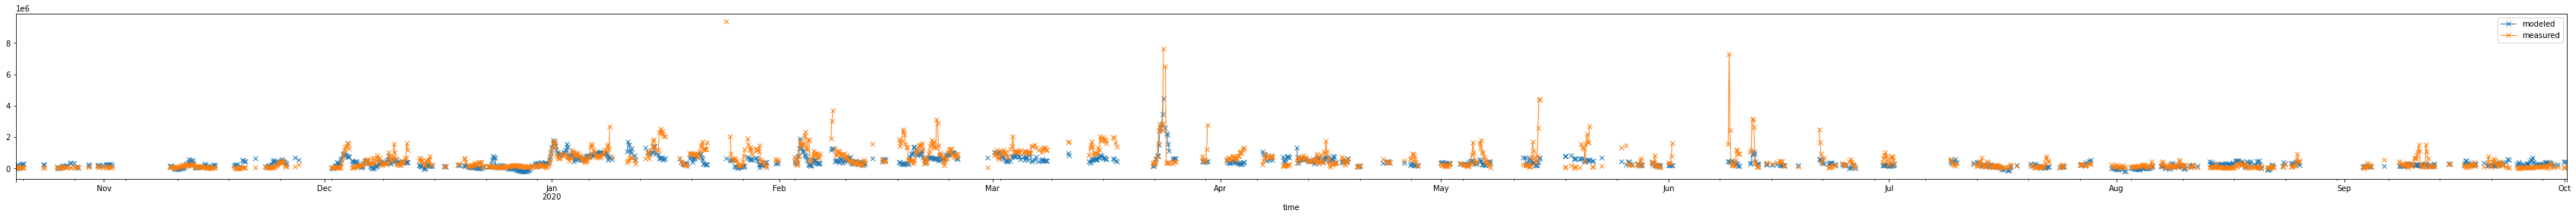

In [14]:
def _plot(rat,dm,dsf,cdf,y):
    AA = rat #should be 1 
    _ = (dm[dsf.columns] * (cdf*rat+inte))
    __ = _.sum(axis=1)[yn].resample('3H').mean()
    __.plot(lw=1,marker='x', label = 'modeled')
    plt.gcf().set_figwidth(60)
#     plt.gca().set_yscale('symlog',linthresh=1e5,linscale=.1)
#     plt.gca().set_ylim(0,None)
    y[yn].resample('3H').mean().plot(lw=1,marker='x', label = 'measured')
    plt.gca().legend()

_plot(rat,dm,dsf,cdf,y)

In [15]:
def get_contr(rat,dm,dsf,cdf,A,yn,inte):
    _cdf = cdf>0
#     AA = rat #should be 1
    _ = (dm[dsf.columns] * (cdf * rat+inte))[yn].T.where(_cdf).T
    __ = _.sum(axis=0)
    a =  __.sort_values()[::-1].cumsum()/__.sum()
    __ = __.where(a<A,0)
    return __

contr =  get_contr(rat,dm,dsf,cdf,1,yn,inte)

In [16]:
contr

0      1172539.0
1     -2922642.0
2            0.0
3            0.0
4            0.0
         ...    
995    2195862.5
996    3683077.5
997    5633115.0
998    5865952.0
999    8331023.5
Length: 1000, dtype: float32

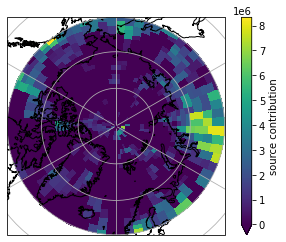

In [17]:
def _plt(ds,contr,ax=None):
    import matplotlib as mpl
    # pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

    _1 = ds['lab'].to_dataframe()['lab'].iloc[:, 1].replace(contr.to_dict()).to_xarray()
    _1.name = 'source contribution'

    if ax is None:
        _, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    _1.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=0)


_plt(ds,contr)

In [18]:
N=20

def _clus(dm,dsf,cdf,contr,ds,yn,rat,inte, N ):
#     N = 20

    from sklearn.cluster import KMeans

    contrs_ = (dm[dsf.columns] * (cdf*rat + inte)).T.where(contr > 0, 0).T[yn]

    _norm = np.sqrt((contrs_ ** 2).sum())

    _nn = contrs_ / _norm
    _nn1 = _nn.dropna(axis=1)

    km = KMeans(N, random_state=123)

    _l = km.fit_predict(_nn1.T.values) + 1

    _l1 = pd.Series(_l, index=_nn1.T.index)
    _nl = (_norm * 0 + _l1)

    def _reorder_by_inf(_nl, contrs_):
        i_ = contrs_.T.groupby(_nl).sum().T.sum().sort_values()[::-1].reset_index()['index']
        i_.index = i_.index + 1
        _order = {v: i for i, v in i_.items()}
        _nl = _nl.replace(_order)
        return _nl

    _nl = _reorder_by_inf(_nl, contrs_)

    d_ = ds['lab'].to_series().replace(_nl.to_dict()).to_xarray()
    d_.name = 'sorted_inf_clusters'
    return d_, contrs_, _nl


(
    ds['sorted_inf_clusters'],
    contrs,
    nl
) = _clus(dm,dsf,cdf,contr,ds,yn,rat,inte,N)





In [19]:
a = regr.alpha_
l = regr.l1_ratio_

In [20]:
a,l

(23.222410239076627, 0.9999)

In [21]:
def _plot_clust_infs(contrs,nl,dsf,cdf,y, rat,dm,inte,yn,N):
    AA = 1
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()
    for i in range(1, N+1):
        (AA*clus_ts[i]).plot(c=plt.get_cmap('tab20')(i - 1),lw=5)
    plt.gcf().set_figwidth(60)
    plt.gca().legend()
    #plt.gca().set_yscale('symlog')

    #(contrs.T.groupby(nl).sum().sum()*rat).plot(c='.7', ls='--', marker='D')

    def plt_model(dm):
        _ = dm[dsf.columns] * (cdf * rat + inte)
        __ = _.sum(axis=1)
        __[yn].resample('3H').mean().plot(lw=1, marker='+', label='modeled', alpha=.5, c='k')

    plt_model(dm)

    y[yn].resample('3H').mean().plot(lw=1, marker='o', label='measured', c='k', mfc='none', alpha=.5)

    plt.legend()
    ymin, ymax = y[yn].quantile([0,.999])
#     plt.gca().set_ylim(ymin,ymax)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33336/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


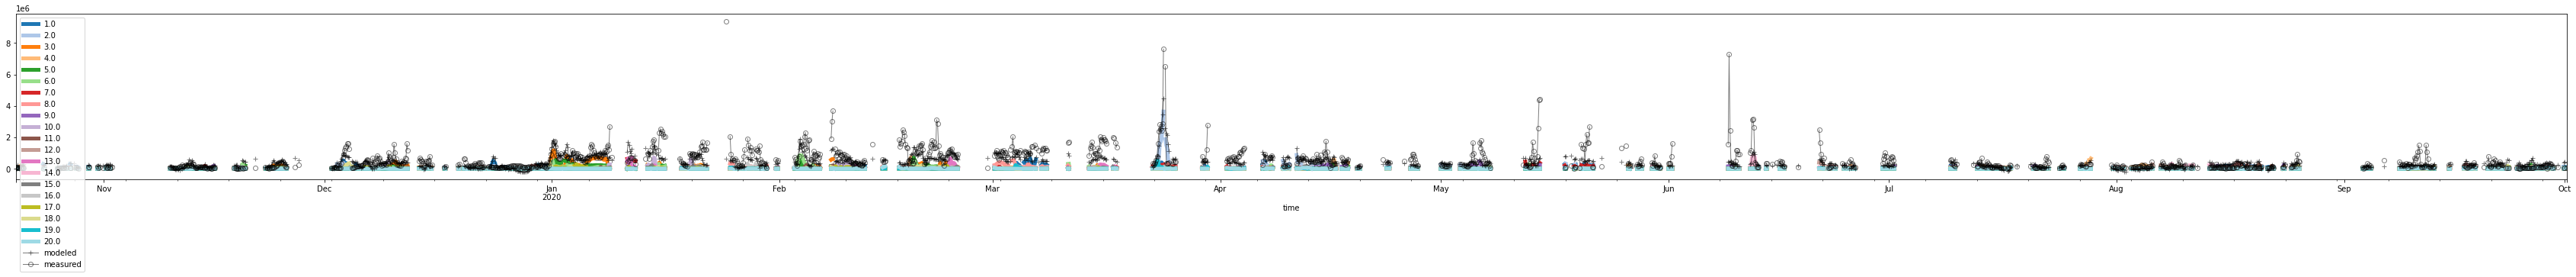

In [22]:
_plot_clust_infs(contrs,nl,dsf,cdf,y, rat, dm,inte,yn,N)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33336/3909890759.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


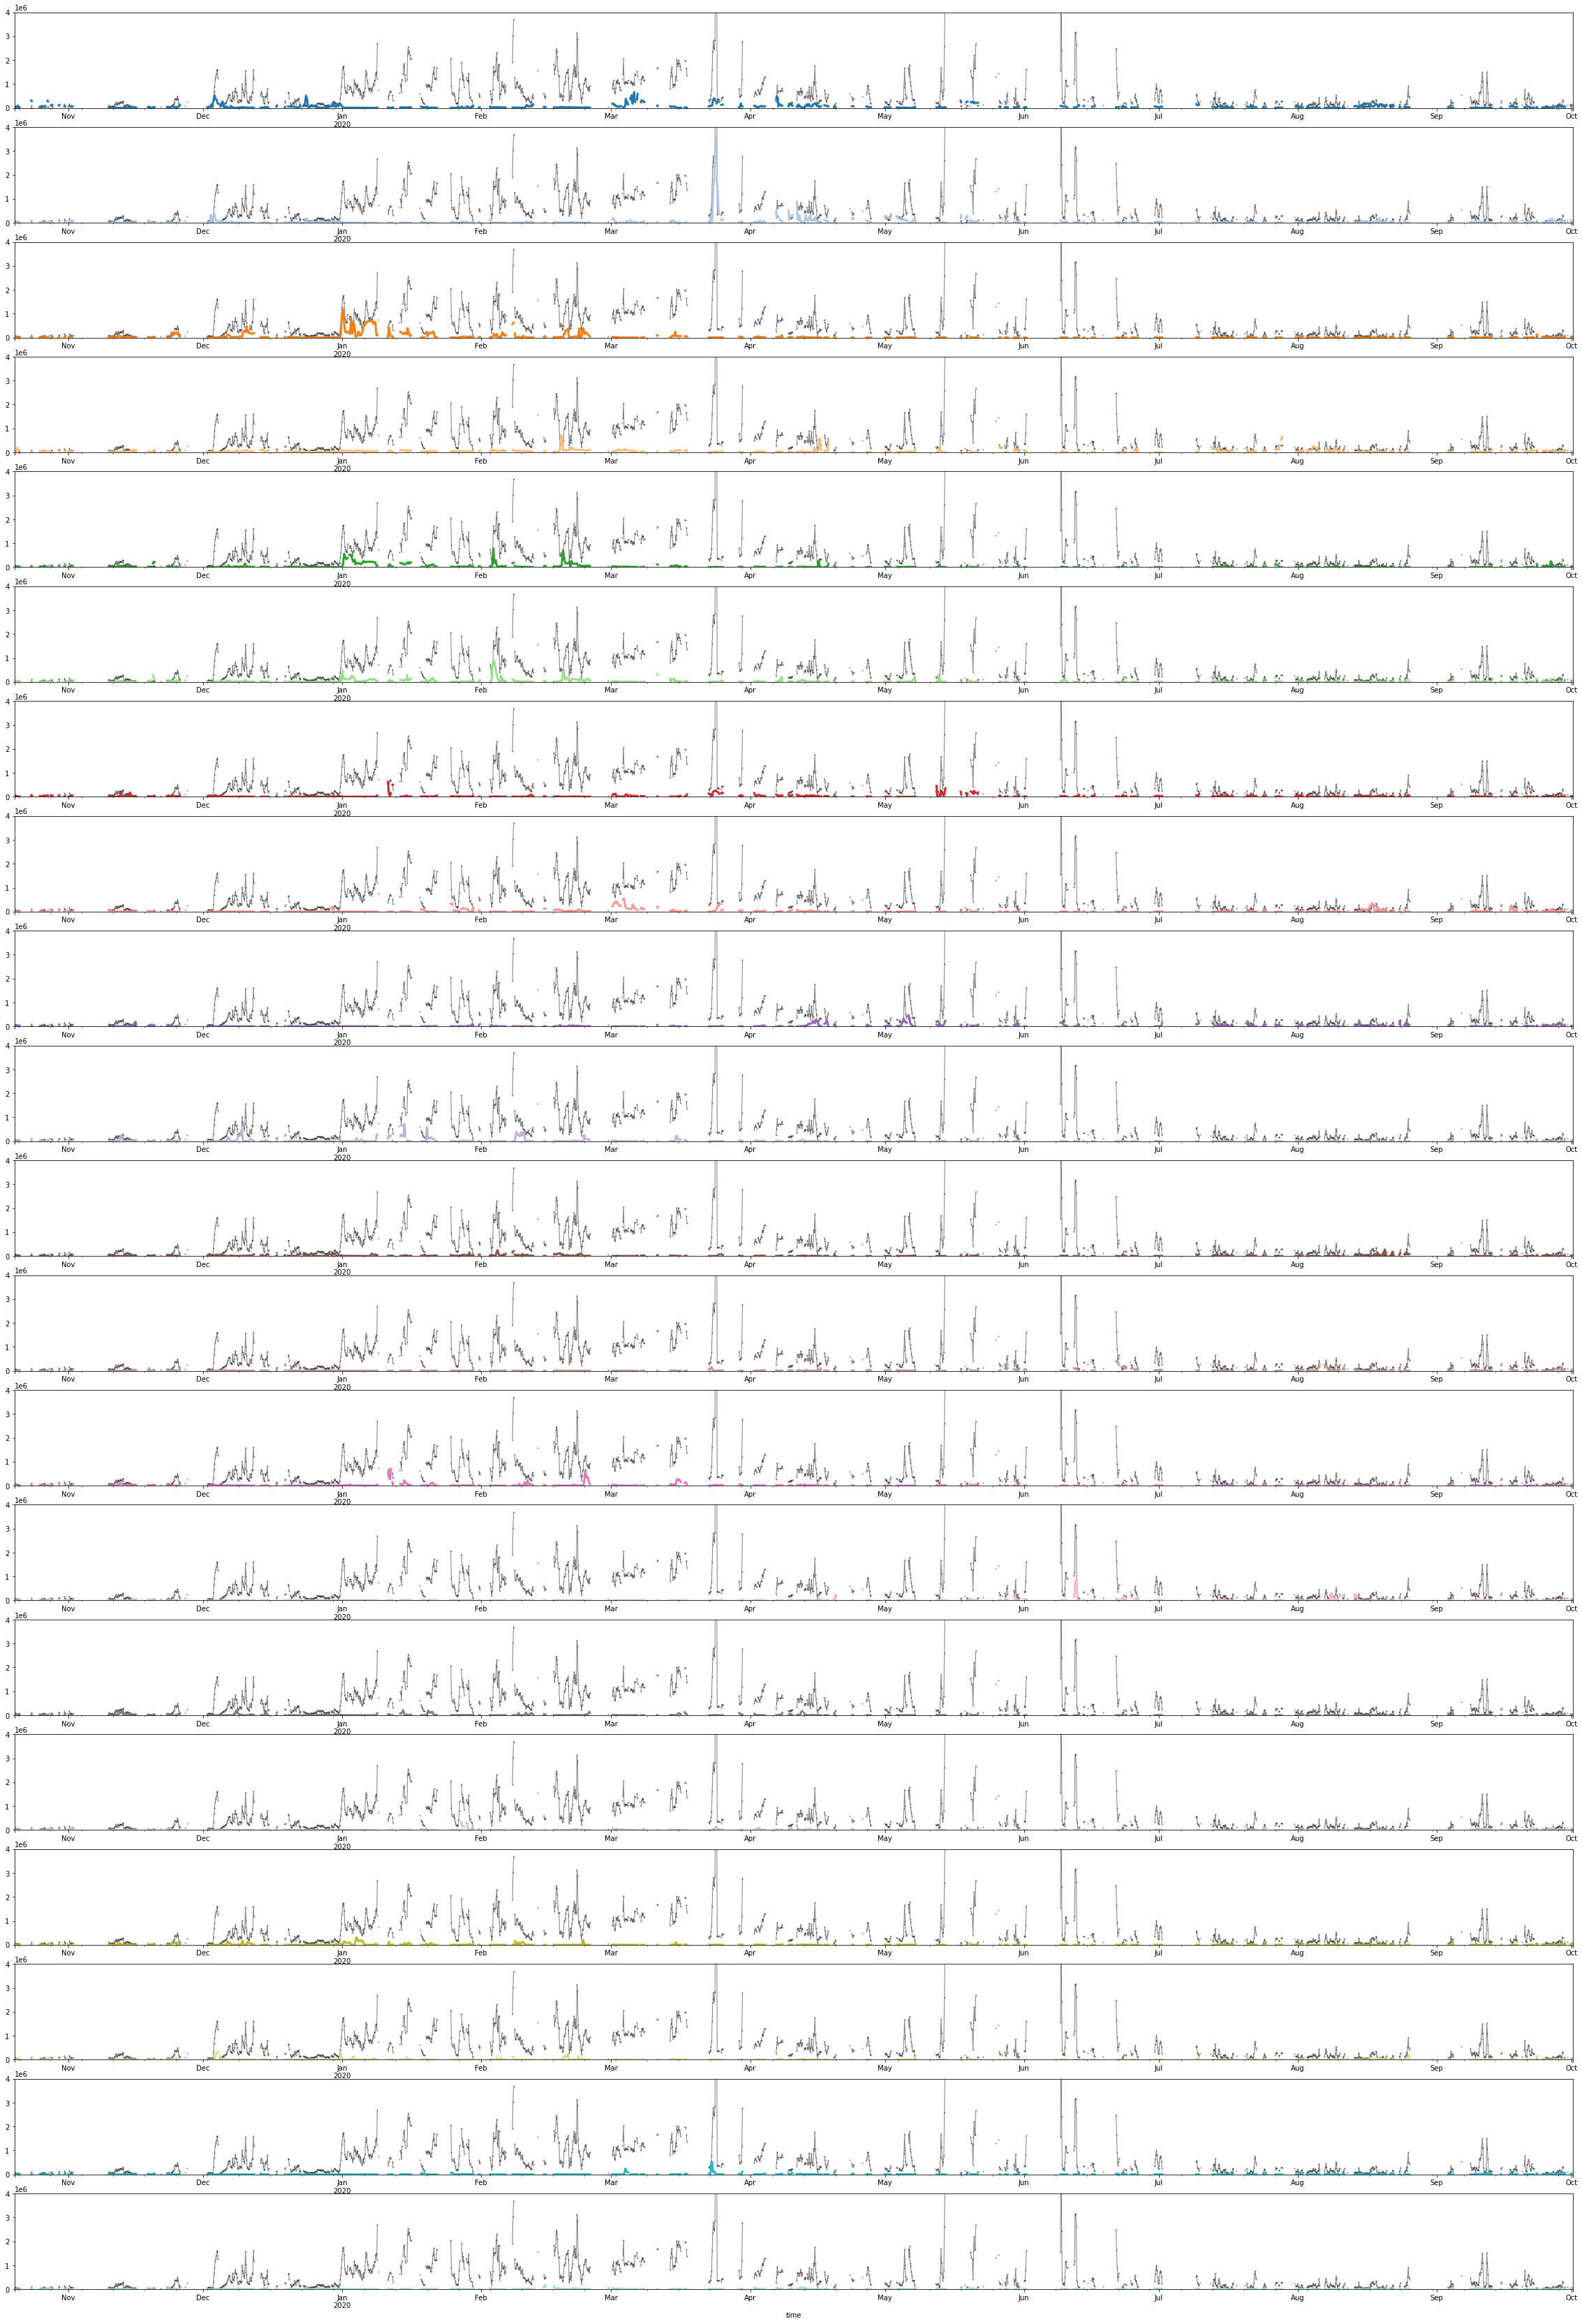

In [23]:
def plot_single_contrs(contrs, nl, yn,y, N):
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()
    f, axs = plt.subplots(N, 1, figsize=(40, 3 * 20), sharey=True)
    axf = axs.flatten()
    for i in range(1, N+1):
        y[yn].resample('3H').mean().plot(lw=1, marker='o', label='measured', c='k', mfc='none', alpha=.5, ax=axf[i - 1],
                                         ms=1)
        clus_ts[i].plot(ax=axf[i - 1], c=plt.get_cmap('tab20')(i - 1), lw=3)
        axf[i - 1].set_ylim(0, 4e6)

plot_single_contrs(contrs, nl, yn,y, N)

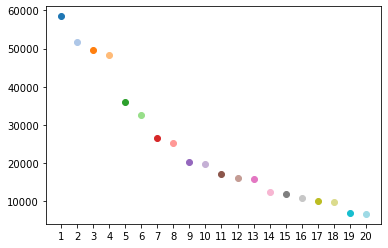

In [24]:
def plt_contrs(contrs,nl,N):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0,N):
        plt.scatter(d.index[i],d.iloc[i],c=[plt.get_cmap('tab20')(i)])
    plt.gca().set_xticks(range(1,21));
plt_contrs(contrs,nl,N)

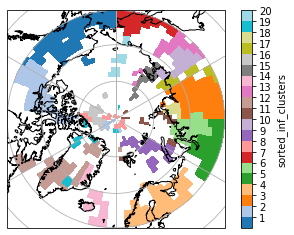

In [25]:
def _plt_influence_clusters(ds):
    import matplotlib as mpl
    _,ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    (ds['sorted_inf_clusters']-.5).plot(ax=ax,transform=ccrs.PlateCarree(),cmap='tab20',
                                        cbar_kwargs={'ticks':range(1,21)},
                                        vmin=0,vmax=20)
_plt_influence_clusters(ds)

# multi elastic net

In [26]:
l

0.9999

In [27]:
aa = np.geomspace(a/10,a*20,36)
CC = 15

LL = l

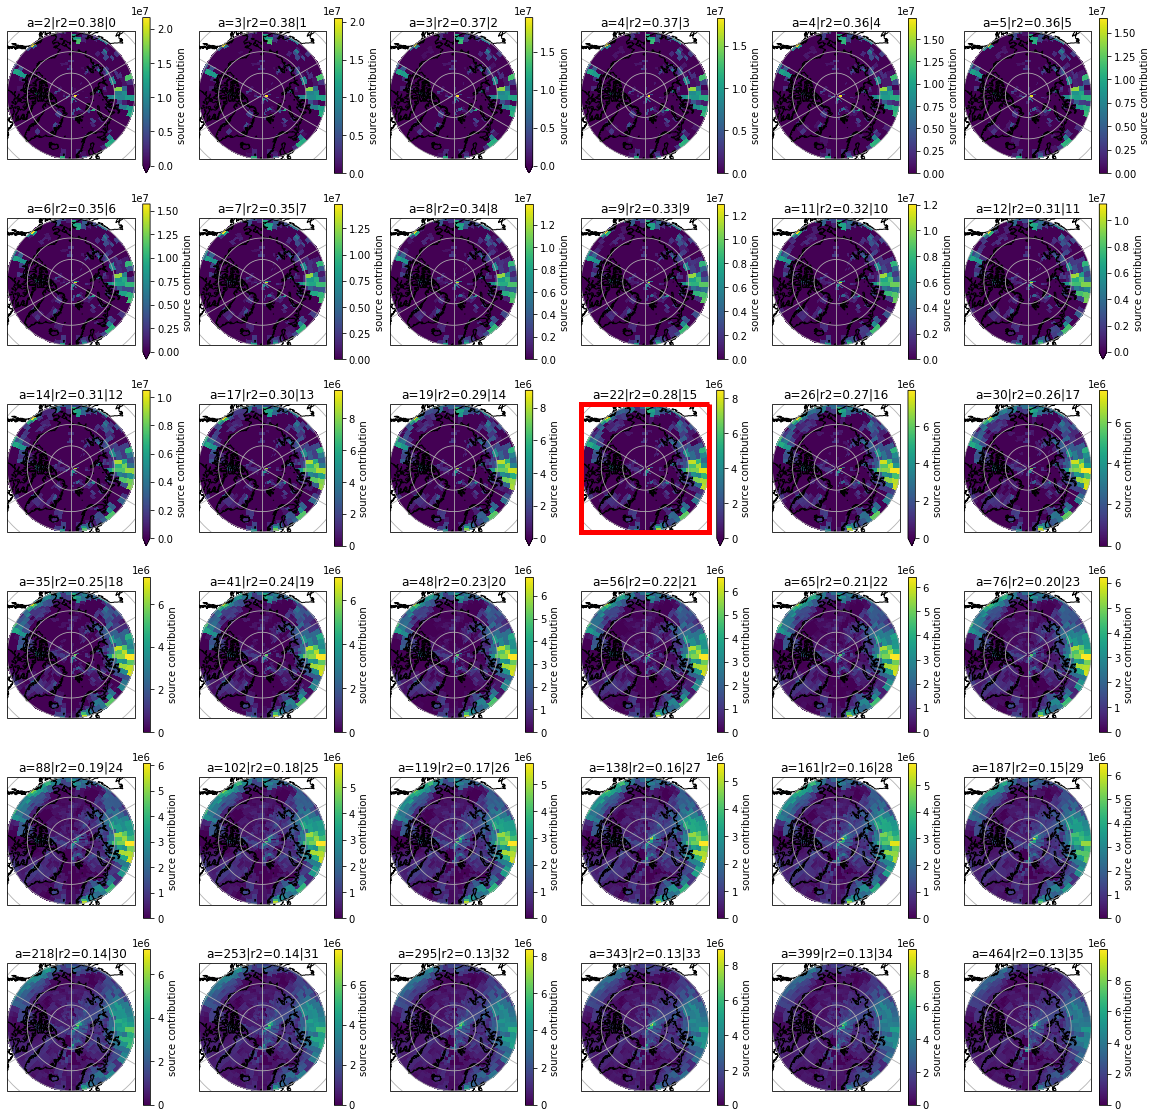

In [28]:
def elastic_net_reg3(dsf, dm, PAR, a, l ):
    from sklearn.linear_model import ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    ### normalize X
    xn = np.sqrt(  (X ** 2).sum()  ) ** (1/1)
    XX = X.divide(xn, axis=1)
    #############


    _y = dm[PAR]
    yn = _y.notna()
    y = _y[yn]
    regr = ElasticNet(a,l1_ratio=l, random_state=123, positive=True, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

#     print(regr.alpha_,regr.l1_ratio_)

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    _cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = _cdf / xn
    return pred, cdf, y, yn, dp, regr

def _multi_plot(aa,CC):
    
    f,axs = plt.subplots(6,6,figsize=(20,20),subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    axf = axs.flatten()
    
    for i_,a_ in enumerate(aa):
        ax = axf[i_]
        pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR,a_,LL)
        r2, rat, inte = get_rat(dp,y,yn)
        contr = get_contr(rat,dm,dsf,cdf,1,yn,inte)
        _plt(ds,contr,ax)
        ax.set_title(f'a={a_:.0f}|r2={r2:.2f}|{i_}')
        if i_ == CC:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(5)
_multi_plot(aa,CC)

# chosen elastic net

In [29]:
pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR,aa[CC],LL)
r2, rat, inte = get_rat(dp,y,yn)

In [30]:
LL,aa[CC]

(0.9999, 22.49380911325758)

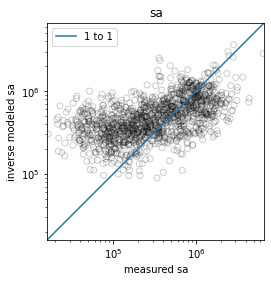

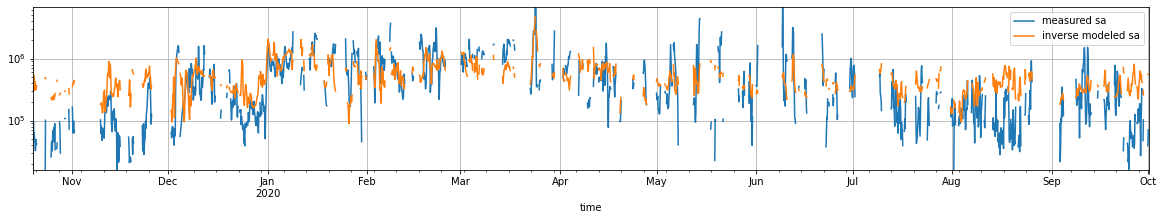

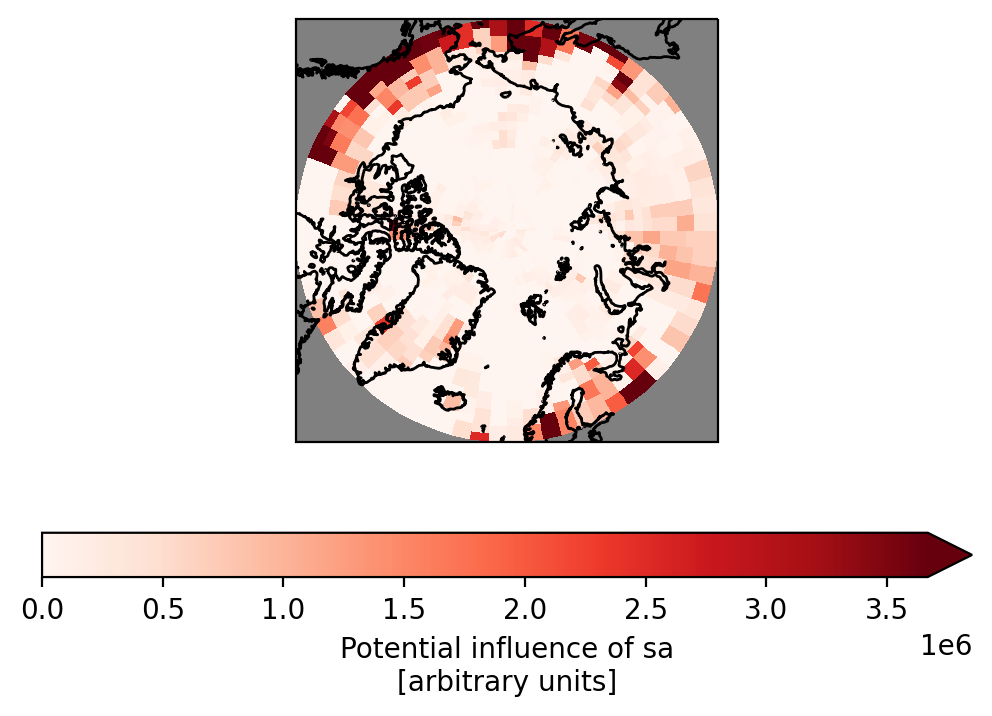

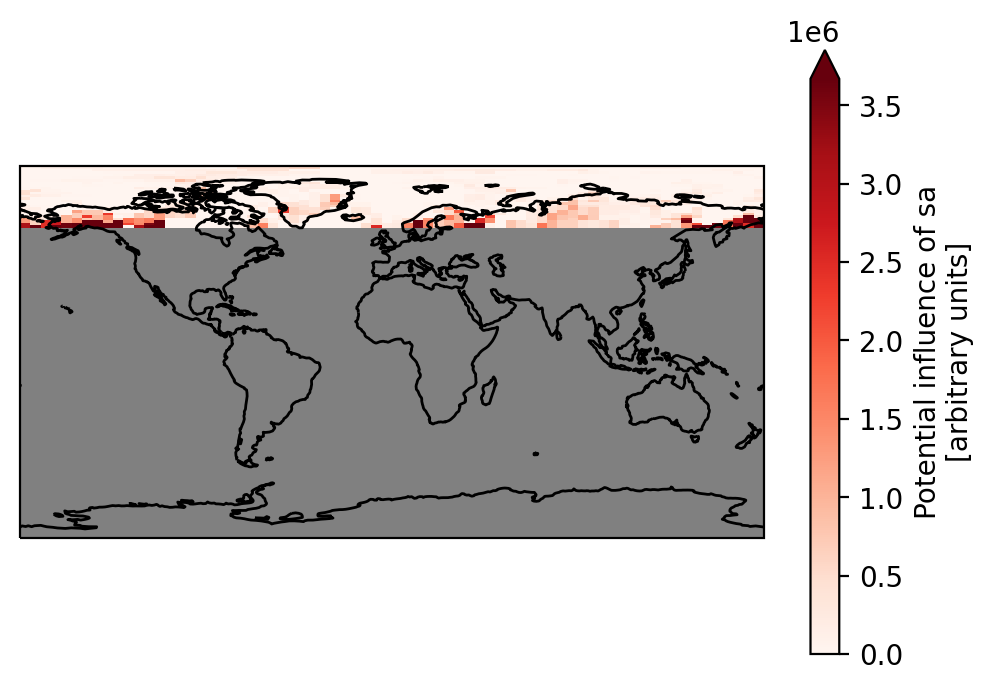

In [31]:
# for PAR in [SA,MSA,IA]:
def plt_el_net():
    
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred*rat+inte, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp*rat+inte, pred*rat+inte, MEA, MOD)
    #rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr

    
regr = plt_el_net()

In [32]:
N = 20
contr = get_contr(rat,dm,dsf,cdf,1, yn,inte)

(
    ds['sorted_inf_clusters'],
    contrs,
    nl
) = _clus(dm,dsf,cdf,contr,ds, yn, rat , inte, N)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33336/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


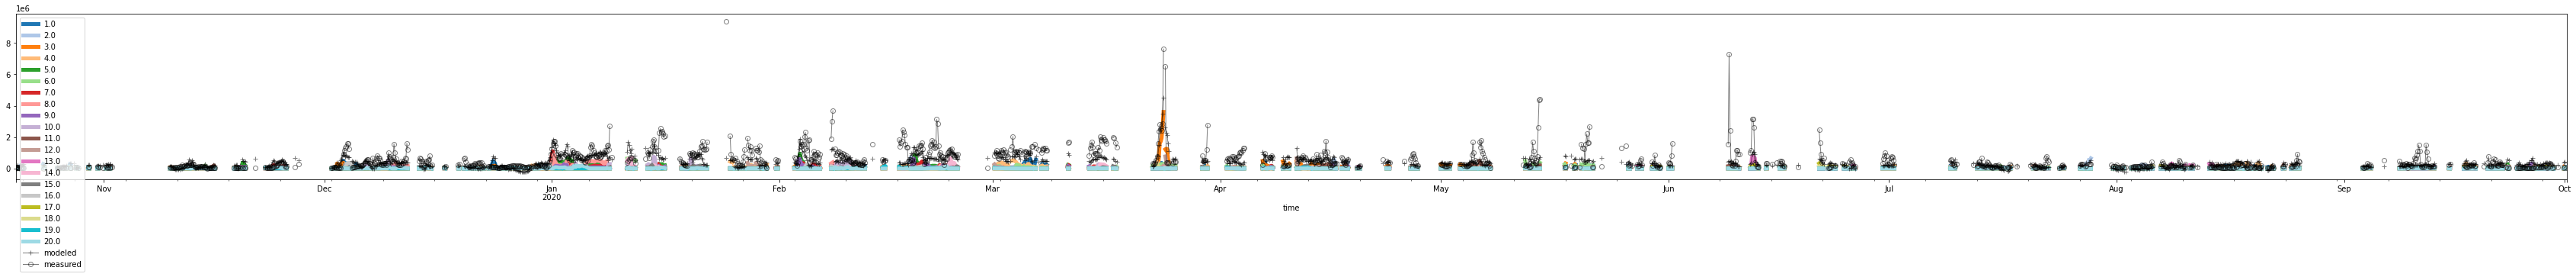

In [33]:
_plot_clust_infs(contrs=contrs,nl=nl,dsf=dsf,cdf=cdf,y=y, rat=rat, dm=dm, inte=inte, yn=yn,N=N)

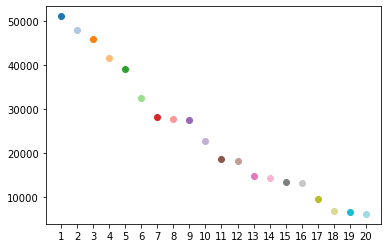

In [34]:
def plt_contrs(contrs,nl):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0,20):
        plt.scatter(d.index[i],d.iloc[i],c=[plt.get_cmap('tab20')(i)])
    plt.gca().set_xticks(range(1,21));
plt_contrs(contrs,nl)

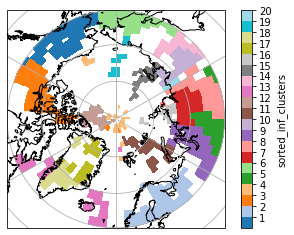

In [35]:
_plt_influence_clusters(ds)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33336/3909890759.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


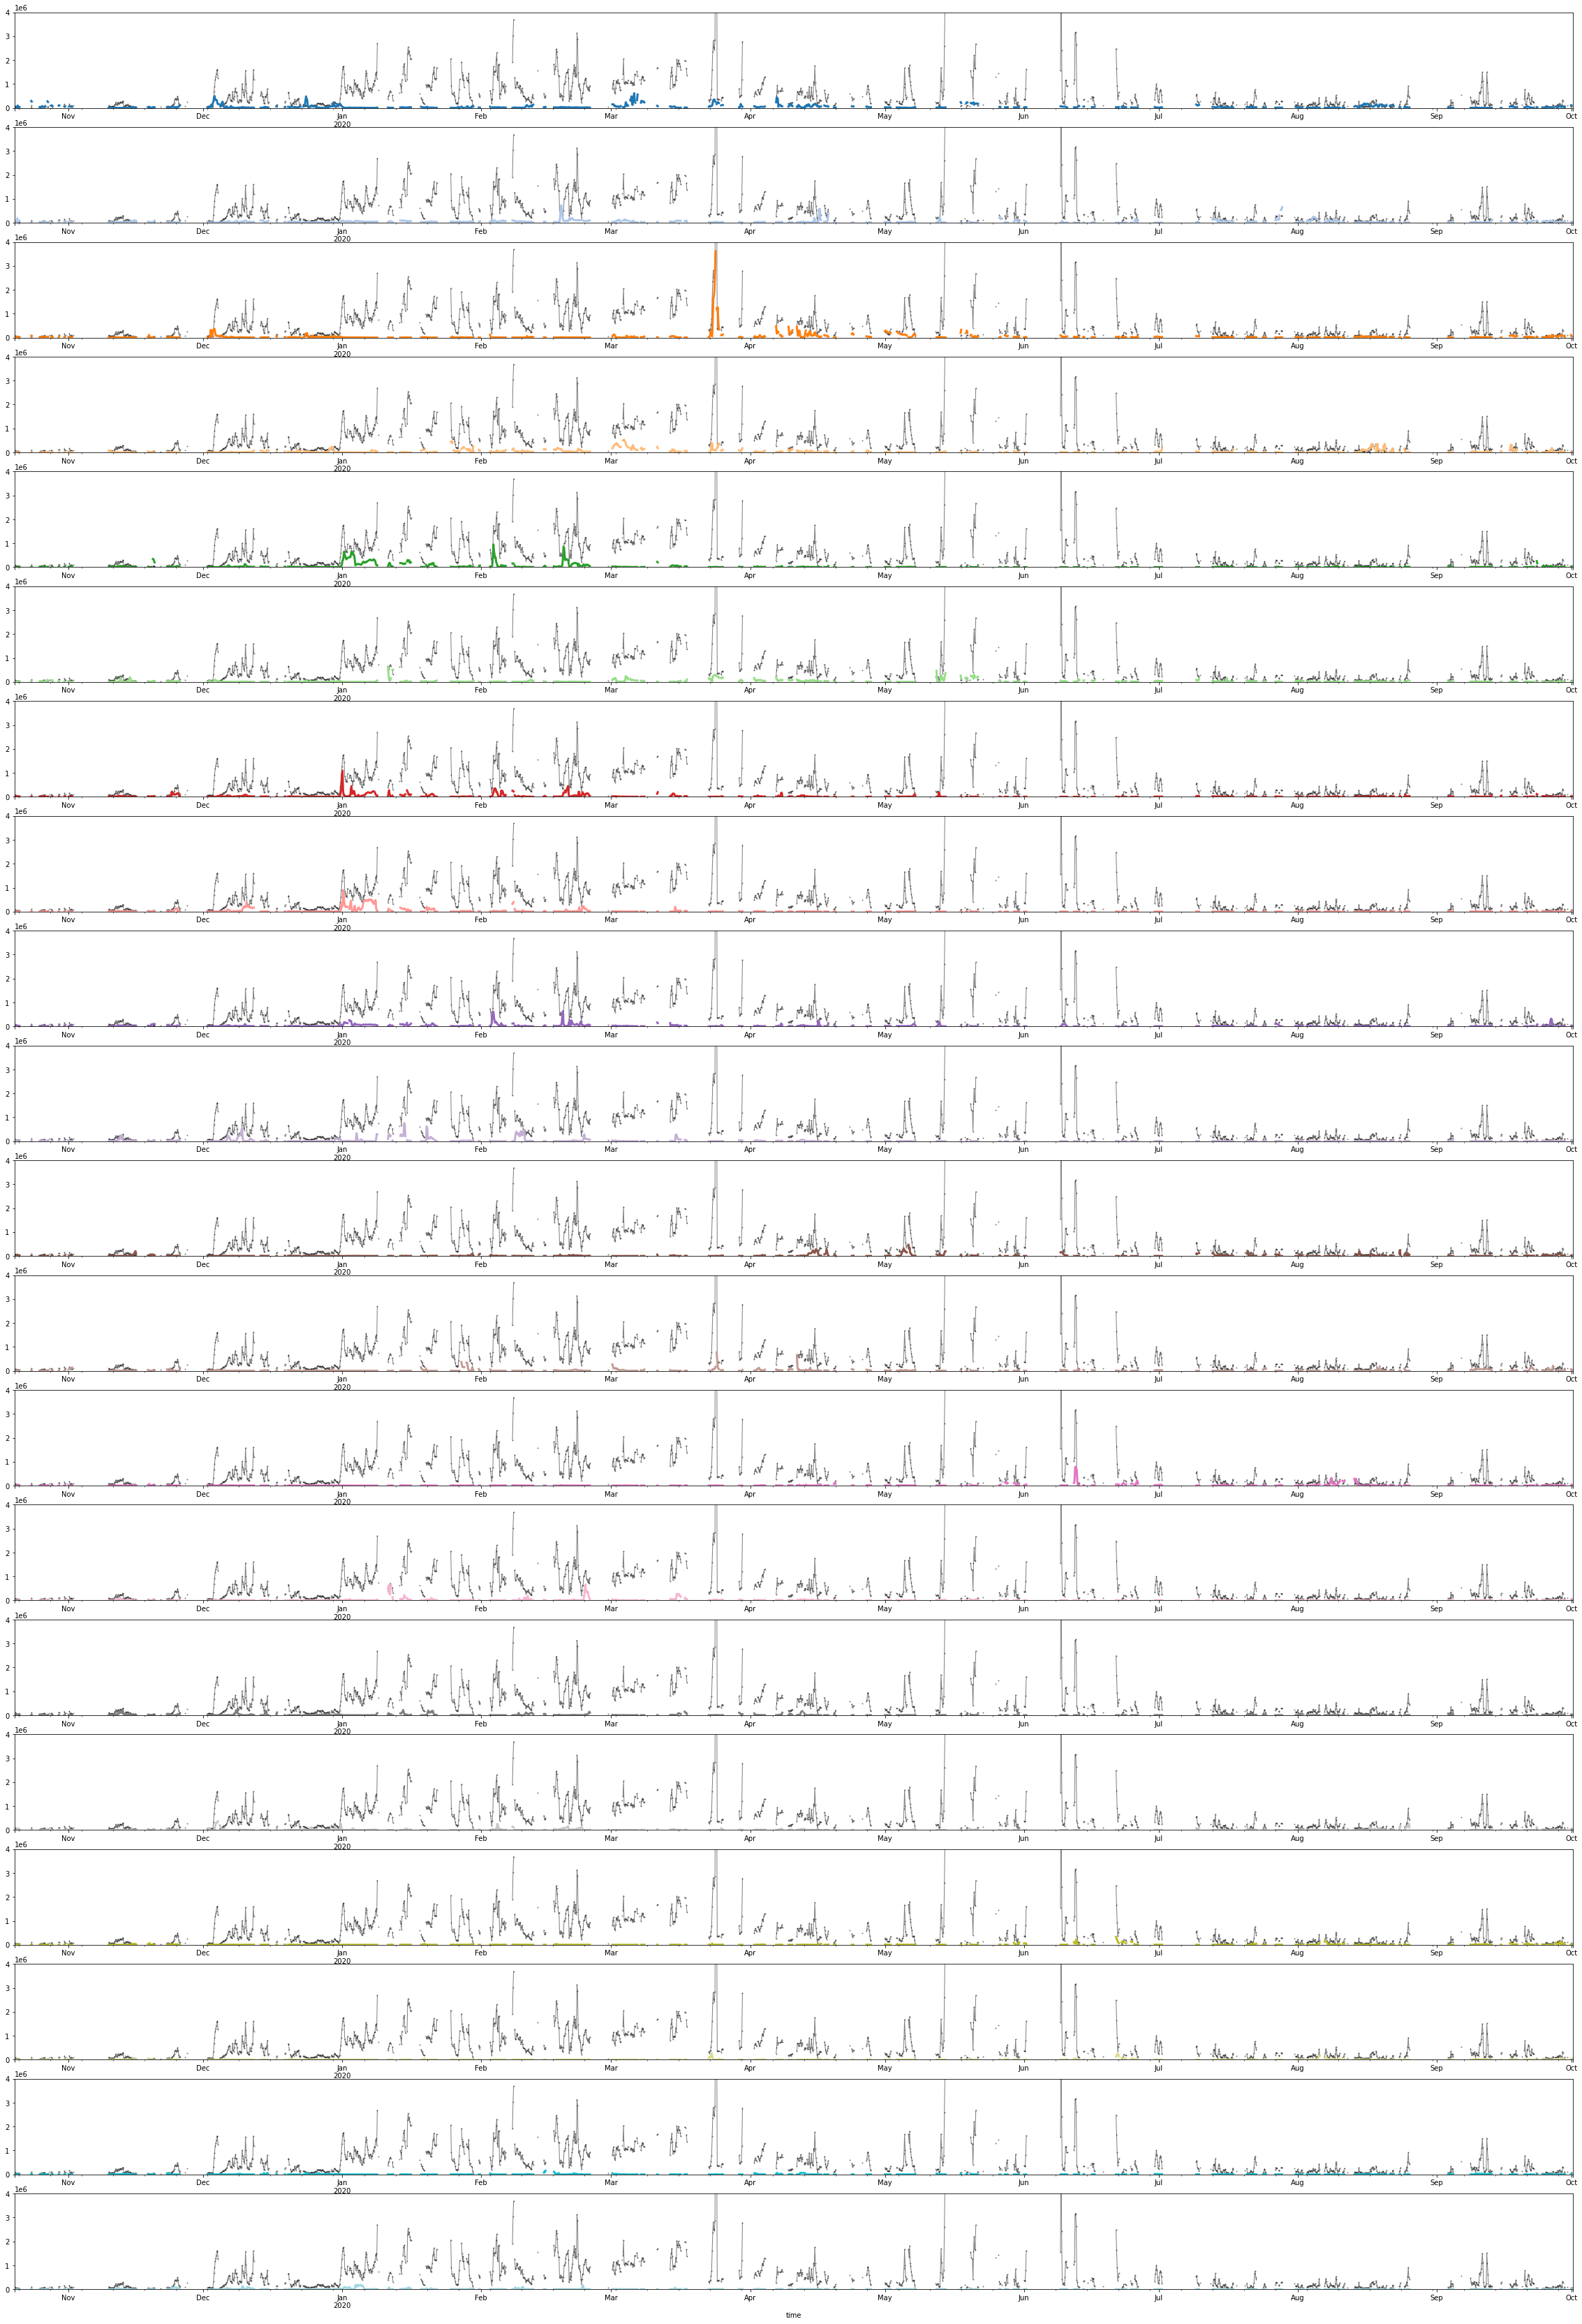

In [36]:
plot_single_contrs(contrs, nl, yn,y,N)

# save data

In [37]:
clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33336/2478368837.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


In [38]:
clus_ts

1.0           2.0            3.0          4.0   \
time                                                                           
2019-10-20 00:00:00   19217.439453  19127.017578   34906.042969  5077.019531   
2019-10-20 03:00:00   18325.140625  21304.748047   32878.351562  4900.511230   
2019-10-20 06:00:00   18815.257812  25760.308594   21673.677734  3361.562988   
2019-10-20 09:00:00   12012.539062  47824.156250   18683.296875  2562.737061   
2019-10-20 12:00:00   47956.984375  38760.453125   25120.158203  4328.367188   
...                            ...           ...            ...          ...   
2020-09-30 18:00:00            NaN           NaN            NaN          NaN   
2020-09-30 21:00:00  109062.515625  29631.912109  106630.882812   936.622742   
2020-10-01 00:00:00  111616.570312  45206.386719   67222.734375   772.475525   
2020-10-01 03:00:00            NaN           NaN            NaN          NaN   
2020-10-01 06:00:00   80180.617188  65941.359375   46986.359375   701.589172   

                             5.0           6.0           7.0           8.0   \
time                                                                          
2019-10-20 00:00:00  13101.832031   8492.791016   9339.098633   2276.517090   
2019-10-20 03:00:00  17954.808594   9464.035156  12914.928711   3296.868164   
2019-10-20 06:00:00  43520.570312  17087.681641  35606.812500  10901.743164   
2019-10-20 09:00:00  19259.748047   7745.518066  14758.905273   3373.379395   
2019-10-20 12:00:00  14220.013672  13908.745117  10294.481445   2668.907959   
...                           ...           ...           ...           ...   
2020-09-30 18:00:00           NaN           NaN           NaN           NaN   
2020-09-30 21:00:00  11586.205078  24912.259766  11158.038086   7981.077637   
2020-10-01 00:00:00  10358.484375  19272.064453   9380.040039   6146.343750   
2020-10-01 03:00:00           NaN           NaN           NaN           NaN   
2020-10-01 06:00:00   9007.589844  12814.385742  10440.240234   6231.039062   

                             9.0           10.0          11.0          12.0  \
time                                                                          
2019-10-20 00:00:00  15575.332031  11624.521484   2657.121338  28280.257812   
2019-10-20 03:00:00  19977.259766  10392.282227   2511.927979  28631.068359   
2019-10-20 06:00:00  60954.125000  30108.695312   2111.817871  13776.175781   
2019-10-20 09:00:00  56698.324219  19474.556641   2224.547363  10903.932617   
2019-10-20 12:00:00  34675.335938  10707.839844   5207.510254  19019.498047   
...                           ...           ...           ...           ...   
2020-09-30 18:00:00           NaN           NaN           NaN           NaN   
2020-09-30 21:00:00  13308.441406  22261.945312   3848.080566  60585.808594   
2020-10-01 00:00:00  13088.090820  31123.142578  13068.141602  37534.578125   
2020-10-01 03:00:00           NaN           NaN           NaN           NaN   
2020-10-01 06:00:00  13943.054688  29316.021484  19268.767578  37165.777344   

                             13.0          14.0          15.0          16.0  \
time                                                                          
2019-10-20 00:00:00   6587.581055    848.655090  36011.664062   6189.351074   
2019-10-20 03:00:00   6506.882812   1004.769104  36349.558594   7105.750977   
2019-10-20 06:00:00   4848.408691   2137.846436  92709.468750  15066.232422   
2019-10-20 09:00:00   3938.123291    795.785339  61286.472656   8578.620117   
2019-10-20 12:00:00   5725.432129   1490.703369  26184.421875   9686.516602   
...                           ...           ...           ...           ...   
2020-09-30 18:00:00           NaN           NaN           NaN           NaN   
2020-09-30 21:00:00   5727.110840  12387.327148   7647.694336   2719.495117   
2020-10-01 00:00:00  14566.323242  12669.309570   9388.502930   6972.000488   
2020-10-01 03:00:00           NaN           NaN           NaN   

In [39]:
clus_ts.to_csv(OUT_FILE)

In [40]:
fu.compressed_netcdf_save(ds,OUT_DS_FILE)

In [41]:
contrs.to_csv(OUT_CONTRS_FILE)

In [42]:
yn.to_csv(OUT_MEAS_FILE)